#### This text classification task aims at building machine learning models for the prediction of expert action using the fault notification document and maintenance action document, to demostrate its ability to suppport expert systems and desion making for MRO (Maintenance, Repair and Overhaul) services. The sequence of action to be implemented include; data preprocessing, exploratory text analysis, text statistics, text extraction (keword and Key phrase), Text classification using the traditional and neural network classifiers, then performance evaluation.

In [1]:
#importing the libraries
import nltk
import numpy as np
import pandas as pd
#import pandas_profiling
from nltk.corpus  import stopwords
from nltk.stem import WordNetLemmatizer
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from wordcloud  import WordCloud
from textwrap import wrap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
from nltk.cluster.util import cosine_distance


In [2]:
#reading the dataset
data = pd.read_csv("NewCSV_faultsData.csv")
data.head(3)

,Parts,Fault Notification,Maintenance Action,Class
0,Part D,F.G. L MAIN INDICATION BLANK.\nTT,"NEW COMPONENTS FITTED; FRONT unit, PUSH BUTTO...",Replacement
1,Part A,"Unit fails Left Standby, Right Standby and Cen...",Conformal Coating stripped from module.\nModul...,No fault found
2,Part A,Unit fails Right Standby component (z701 ) dur...,Conformal Coating stripped from module.\nModul...,No fault found


In [3]:
data=data.astype('string')
data.dtypes

Parts                 string
Fault Notification    string
Maintenance Action    string
Class                 string
dtype: object

In [4]:
# renaming the columns
data= data.rename(columns = {"Maintenance Action": "MA",
                                  "Fault Notification":"FN"})

In [5]:
#checking for null values
data.isnull()

,Parts,FN,MA,Class
0,False,False,False,False
1,False,False,False,False
2,False,False,False,False
3,False,False,False,False
4,False,False,False,False
...,...,...,...,...
1495,False,False,False,False
1496,False,False,False,False
1497,False,False,False,False
1498,False,False,False,False


In [6]:
#loading the dataset
data = pd.read_csv("NewCSV_faultsData.csv")
display(data.info(),data.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Parts               1500 non-null   object
 1   Fault Notification  1500 non-null   object
 2   Maintenance Action  1500 non-null   object
 3   Class               1500 non-null   object
dtypes: object(4)
memory usage: 47.0+ KB


None

(1500, 4)

#### The data has no null values within the four columns and 1500 rows of observaion

## Explorative Data Analysis

In [7]:
#checking for balance in the dataset
data.groupby ('Class').describe()

Parts                     Fault Notification         \
               count unique     top freq              count unique   
Class                                                                
Modification     500      4  Part B  388                500    451   
No fault found   500      4  Part B  458                500    438   
Replacement      500      5  Part B  201                500    497   

                                                                        \
                                                              top freq   
Class                                                                    
Modification                                     SOFTWARE UPGRADE    7   
No fault found                      NO REASON GIVEN ON PAPERWORK    31   
Replacement     B2093-E5-3 PartU LEAKAGE FAULT\r\nEASA Form 1/...    2   

               Maintenance Action         \
                            count unique   
Class                                      
Modification                  500    464   
No fault found                500    338   
Replacement                   500    494   

                                                                        
                                                              top freq  
Class                                                                   
Modification    Unit modified from @@5059-14-20 to @@5059-14-3...    5  
No fault found  Mods Nil\r\nNo fault found\r\nUnit final teste...   14  
Replacement     PSM replaced.\r\nUnit final tested iaw CMM28-4...    3

In [8]:
data['Class'].value_counts()

Replacement       500
No fault found    500
Modification      500
Name: Class, dtype: int64

Replacement = 500
No fault found = 500
Modification = 500


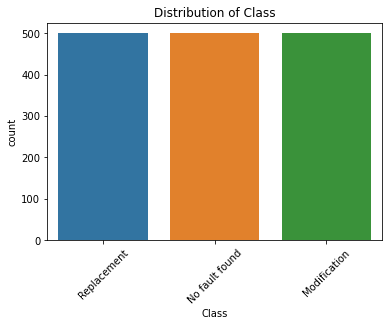

In [9]:
print(f'Replacement = {len(data[data["Class"] == "Replacement"])}')
print(f'No fault found = {len(data[data["Class"] == "No fault found"])}')
print(f'Modification = {len(data[data["Class"] == "Modification"])}')


#Visualizing the distribution of the class
sns.countplot(x=data['Class'], order = data.Class.value_counts().index)
plt.title('Distribution of Class',)  
plt.xticks(rotation=45)
plt.show()

Part A = 26
Part B= 1047
Part C = 261
Part D = 107
Part E = 59


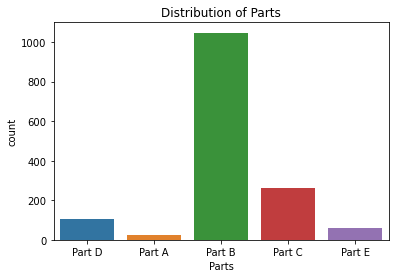

In [10]:
print(f'Part A = {len(data[data["Parts"] == "Part A"])}')
print(f'Part B= {len(data[data["Parts"] == "Part B"])}')
print(f'Part C = {len(data[data["Parts"] == "Part C"])}')
print(f'Part D = {len(data[data["Parts"] == "Part D"])}')
print(f'Part E = {len(data[data["Parts"] == "Part E"])}')


#Visualizing the distribution of the Parts
%matplotlib inline
sns.countplot(data['Parts'])
plt.title('Distribution of Parts',)
plt.show()

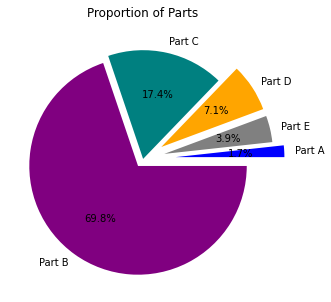

Parts
Part A      26
Part B    1047
Part C     261
Part D     107
Part E      59
dtype: int64

In [11]:
#Visualizing the size of parts in proportion to the total number of observation

# import the pyplot library
import matplotlib.pyplot as plotter
x = data.Parts.value_counts().sort_values()

plt.figure(figsize=(5, 5))
colors  = ("blue", "gray", "orange", "teal", "purple")
ax = plt.pie(x = x, labels=x.index, autopct = '%1.1f%%', explode = [0.3,0.2,0.2, 0.0, 0.08], colors=colors)
plt.title('Proportion of Parts')

plt.show()

data.groupby('Parts').size()

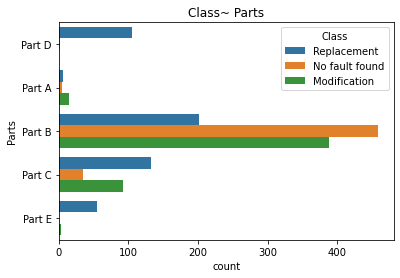

Class,Modification,No fault found,Replacement
Parts,,,
Part A,15.0,5.0,6.0
Part B,388.0,458.0,201.0
Part C,93.0,35.0,133.0
Part D,NaN,2.0,105.0
Part E,4.0,NaN,55.0


In [12]:
#Visualizing the class distribution within the Parts
ax=sns.countplot(y=data['Parts'], hue=data['Class'] )
plt.title('Class~ Parts')
plt.show()

a=data.groupby(['Parts', 'Class'])['Class'].count().unstack()
a

In [13]:
# renaming the columns
data= data.rename(columns = {"Maintenance Action": "MA",
                                  "Fault Notification":"FN"})

### Checking data statistics before pre-processing the text 

In [14]:
data.FN.str.len().describe()

count    1500.000000
mean       64.314667
std        62.282178
min         3.000000
25%        31.000000
50%        48.000000
75%        78.000000
max      1506.000000
Name: FN, dtype: float64

In [15]:
data.MA.str.len().describe()

count    1500.000000
mean      173.272000
std       125.581431
min        23.000000
25%        93.750000
50%       143.000000
75%       199.000000
max       986.000000
Name: MA, dtype: float64

In [16]:
#For the Maintenance Action

import collections
c = collections.Counter(data.MA)

#Checking the number of unique words
num_unique_words =len(c)
print (num_unique_words)

c.most_common(5)

1295


[('Mods Nil\r\nNo fault found\r\nUnit final tested to CMM 28-42-36 Vol.1 xxfhjyj.4.',
  14),
 ('No fault found\r\nUNIT FINAL TESTED TO CMM  xxfhjyj.3', 14),
 ('Mods 01\r\nNo fault found\r\nUnit final tested to CMM  Vol.1 xxfhjyj.4',
  10),
 ('Mods 01\r\nNo fault found\r\nUnit final tested to CMM  Vol.1 xxfhjyj.4.',
  10),
 ('Mods Nil\r\nNo fault found\r\nUnit final tested to CMM 28-42-36 Vol.1 xxfhjyj.4',
  10)]

In [17]:
#For the Fault Notification

import collections
c = collections.Counter(data.FN)

#Checking the number of unique words
num_unique_words =len(c)
print (num_unique_words)

c.most_common(5)

1379


[('NO REASON GIVEN ON PAPERWORK ', 37),
 ('NO REASON GIVEN ON PAPERWORK', 28),
 ('SOFTWARE UPGRADE', 7),
 ('INDICATING COMPUTER SOFTWARE UPGRADE', 6),
 ('NOT STxxxD', 5)]

## Data Processing using NLTK

### Performing case transformation

In [18]:

data['MA_lw']=data['MA'].str.lower()

data['MA_lw']

0        new components fitted; front unit, push butto...
1       conformal coating stripped from module.\nmodul...
2       conformal coating stripped from module.\nmodul...
3       conformal coating stripped from module.\nmodul...
4       customer does not require sil 28-ont-001\nno f...
                              ...                        
1495    removed icm1 and replaced with new 1762-3, 910...
1496    replaced diodes db114 on both unit bs. unit re...
1497    replaced ic 42 on the center main component ca...
1498    replaced psu (40-675-2075, sti350) with psu (4...
1499    replaced the power supply at ge, the unit pass...
Name: MA_lw, Length: 1500, dtype: object

In [19]:
data['FN_lw']=data['FN'].str.lower()
data['FN_lw']


0                      f.g.  l main indication blank.\ntt
1       unit fails left standby, right standby and cen...
2       unit fails right standby component (z701 ) dur...
3       unit fails right main p. bite test during cycl...
4                 re-sequence mr1 056135 f part ch2 fault
                              ...                        
1495          failed. test and repair\r\nwarranty claimed
1496              refling sequencing inop\r\ndual release
1497                        diff between calc and total f
1498    unit found failing in chp #6 intermittently\r\...
1499                         sts msg f quantity channel. 
Name: FN_lw, Length: 1500, dtype: object

### Noise Removal

In [20]:
#handling punctuations and special Characters 
data2 = data.replace("/","")

#Removing Punctuations
import string
string.punctuation

def remove_punctuation(txt):
    txt_nopunct = "".join([c for c in txt if c not in string.punctuation])
    return txt_nopunct

#creating new clean input data
data2['MA_ptn'] = data['MA_lw'].apply(lambda x: remove_punctuation(x))
#data2.head()
data2['MA_ptn'][:3]

0     new components fitted front unit push button ...
1    conformal coating stripped from module\nmodule...
2    conformal coating stripped from module\nmodule...
Name: MA_ptn, dtype: object

In [21]:
#handling punctuations and special Characters
import string
string.punctuation

def remove_punctuation(txt):
    txt_nopunct = "".join([c for c in txt if c not in string.punctuation])
    return txt_nopunct

#creating new clean input data
data2['FN_ptn'] = data['FN_lw'].apply(lambda x: remove_punctuation(x))
#data2.head()
data2['FN_ptn'][:3]

0                      fg  l main indication blank\ntt
1    unit fails left standby right standby and cent...
2    unit fails right standby component z701  durin...
Name: FN_ptn, dtype: object

### Tokeniziation

In [22]:
import re

def tokenize(txt):
    tokens = re.split('\W+', txt)
    return tokens


data2['MA_tkn'] = data2['MA_ptn'].apply(lambda x: tokenize(x.lower()))

#data2.head()
data2['MA_tkn'][:3]

0    [, new, components, fitted, front, unit, push,...
1    [conformal, coating, stripped, from, module, m...
2    [conformal, coating, stripped, from, module, m...
Name: MA_tkn, dtype: object

In [23]:
import re

def tokenize(txt):
    tokens = re.split('\W+', txt)
    return tokens


data2['FN_tkn'] = data2['FN_ptn'].apply(lambda x: tokenize(x.lower()))

#data2.head()
data2['FN_tkn'][:3]

0                 [fg, l, main, indication, blank, tt]
1    [unit, fails, left, standby, right, standby, a...
2    [unit, fails, right, standby, component, z701,...
Name: FN_tkn, dtype: object

##### Applying Stemming

In [24]:
from nltk.stem.porter import PorterStemmer
porter_stemmer = PorterStemmer()

def stemming(tokenized_text):
    text = [porter_stemmer.stem(word) for word in tokenized_text]
    return text

data2['MA_stm'] = data2['MA_tkn'].apply(lambda x: stemming(x))
data2['MA_stm'][:]

0       [, new, compon, fit, front, unit, push, button...
1       [conform, coat, strip, from, modul, modul, ret...
2       [conform, coat, strip, from, modul, modul, ret...
3       [conform, coat, strip, from, modul, modul, ret...
4       [custom, doe, not, requir, sil, 28ont001, no, ...
                              ...                        
1495    [remov, icm1, and, replac, with, new, 17623, 9...
1496    [replac, diod, db114, on, both, unit, bs, unit...
1497    [replac, ic, 42, on, the, center, main, compon...
1498    [replac, psu, 406752075, sti350, with, psu, 40...
1499    [replac, the, power, suppli, at, ge, the, unit...
Name: MA_stm, Length: 1500, dtype: object

In [25]:
from nltk.stem.porter import PorterStemmer
porter_stemmer = PorterStemmer()

def stemming(tokenized_text):
    text = [porter_stemmer.stem(word) for word in tokenized_text]
    return text

data2['FN_stm'] = data2['FN_tkn'].apply(lambda x: stemming(x))
data2['FN_stm'][:]

0                         [fg, l, main, indic, blank, tt]
1       [unit, fail, left, standbi, right, standbi, an...
2       [unit, fail, right, standbi, compon, z701, dur...
3       [unit, fail, right, main, p, bite, test, dure,...
4              [resequ, mr1, 056135, f, part, ch2, fault]
                              ...                        
1495           [fail, test, and, repair, warranti, claim]
1496                  [refl, sequenc, inop, dual, releas]
1497                 [diff, between, calc, and, total, f]
1498    [unit, found, fail, in, chp, 6, intermitt, eas...
1499                    [st, msg, f, quantiti, channel, ]
Name: FN_stm, Length: 1500, dtype: object

### Lemmatization using wordnetlemmatizer

In [26]:

#WordNet lexical database for lemmatization
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

def lemmatization(token_txt):
    text = [wordnet_lemmatizer.lemmatize(word) for word in token_txt]
    return text

data2['MA_lm'] = data2['MA_stm'].apply(lambda x : lemmatization(x))

data2['MA_lm'][:2] 

0    [, new, compon, fit, front, unit, push, button...
1    [conform, coat, strip, from, modul, modul, ret...
Name: MA_lm, dtype: object

In [27]:

#WordNet lexical database for lemmatization
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

def lemmatization(token_txt):
    text = [wordnet_lemmatizer.lemmatize(word) for word in token_txt]
    return text

data2['FN_lm'] = data2['FN_stm'].apply(lambda x : lemmatization(x))

data2['FN_lm'][:2]

0                      [fg, l, main, indic, blank, tt]
1    [unit, fail, left, standbi, right, standbi, an...
Name: FN_lm, dtype: object

### Stopword Removal

In [28]:
stopwords = nltk.corpus.stopwords.words('english')


def remove_stopwords(txt_tokenized):
    txt_clean = [word for word in txt_tokenized if word not in stopwords]
    return txt_clean

data2['MA_stpw'] = data2['MA_lm'].apply(lambda x: remove_stopwords(x))
data2['MA_stpw'][:3]

0    [, new, compon, fit, front, unit, push, button...
1    [conform, coat, strip, modul, modul, retest, u...
2    [conform, coat, strip, modul, modul, retest, u...
Name: MA_stpw, dtype: object

In [29]:
stopwords = nltk.corpus.stopwords.words('english')


def remove_stopwords(txt_tokenized):
    txt_clean = [word for word in txt_tokenized if word not in stopwords]
    return txt_clean

data2['FN_stpw'] = data2['FN_lm'].apply(lambda x: remove_stopwords(x))
data2['FN_stpw'][:3]

0                      [fg, l, main, indic, blank, tt]
1    [unit, fail, left, standbi, right, standbi, ce...
2    [unit, fail, right, standbi, compon, z701, dur...
Name: FN_stpw, dtype: object

In [30]:
def flatten(data2):
    for x in data2:
        if hasattr(x, '__iter__') and not isinstance(x, str):
            for y in flatten(x):
                yield y
        else:
            yield x

### Checking for the data statistics post pre-processing operation

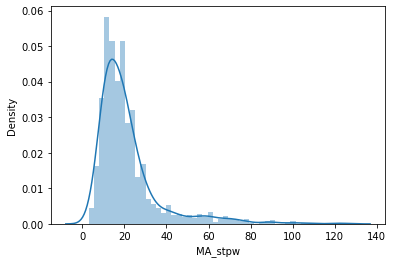

In [31]:
#Applying the distplot
sns.distplot(data2.MA_stpw.str.len())

plt.show()

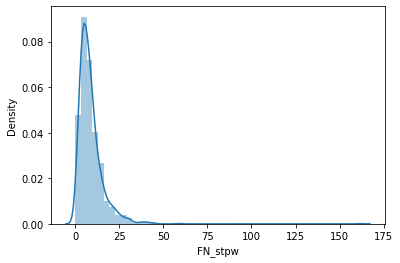

In [32]:
sns.distplot(data2.FN_stpw.str.len())

plt.show()

In [33]:
data2.FN_stpw.str.len().describe()

count    1500.000000
mean        8.808000
std         7.600723
min         0.000000
25%         4.000000
50%         7.000000
75%        11.000000
max       162.000000
Name: FN_stpw, dtype: float64

In [34]:
data2.MA_stpw.str.len().describe()

count    1500.000000
mean       21.511333
std        15.643647
min         3.000000
25%        12.000000
50%        17.000000
75%        24.000000
max       126.000000
Name: MA_stpw, dtype: float64

##### The plots and the descriptions show that the lenght of the data has reduced for Fault Notification from a maximum of 1506 and an average of  64 number of words to 162 and 8 respectively, while for the Maintenance Action, the lenght also reduced from a maximum of 986 and an average of  173 number of words to 126 and 21 respectively. This demostrates the efficiency of the operation in the removal of irrelevant values with the text data.

In [35]:
#extracting the right features to create a new dataframe for the text extraction task
data3= pd.DataFrame([data2.MA_stpw,data2.FN_stpw,data2.Class]).transpose()
data3.head(2)

,MA_stpw,FN_stpw,Class
0,"[, new, compon, fit, front, unit, push, button...","[fg, l, main, indic, blank, tt]",Replacement
1,"[conform, coat, strip, modul, modul, retest, u...","[unit, fail, left, standbi, right, standbi, ce...",No fault found


### Text Extraction and Analysis

##### Visualizing commonly found words with wordcloud

In [36]:
#joining all the string values in the list.

data3["FN_stpw"]= data3["FN_stpw"].str.join(" ")
data3["MA_stpw"]= data3["MA_stpw"].str.join(" ")  
data3.head()

,MA_stpw,FN_stpw,Class
0,new compon fit front unit push button xxxxe s...,fg l main indic blank tt,Replacement
1,conform coat strip modul modul retest unit fau...,unit fail left standbi right standbi centr mai...,No fault found
2,conform coat strip modul modul retest unit fau...,unit fail right standbi compon z701 dure p pin...,No fault found
3,conform coat strip modul modul retest unit fau...,unit fail right main p bite test dure cycl 4 h...,No fault found
4,custom doe requir sil 28ont001 fault found uni...,resequ mr1 056135 f part ch2 fault,No fault found


## Word Cloud for Keyword Visualization

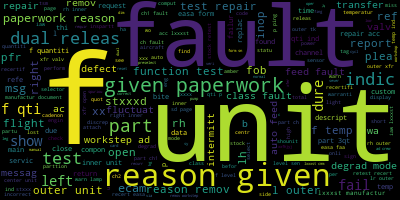

In [37]:
#Visualizing the keywords in the 'no fault found' class of Fault notification

# joining all the sentences.
corpus1=' '.join(data3[data3.Class == 'No fault found'].FN_stpw)
# generating word cloud
word_cloud=WordCloud().generate(corpus1)
img=word_cloud.to_image()
img

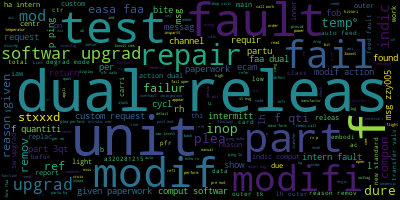

In [38]:
#Visualizing the keywords in the 'Modification' class of Fault notification

# joining all the sentences.
corpus2=' '.join(data3[data3.Class == 'Modification'].FN_stpw)
# generating word cloud
word_cloud=WordCloud().generate(corpus2)
img=word_cloud.to_image()
img

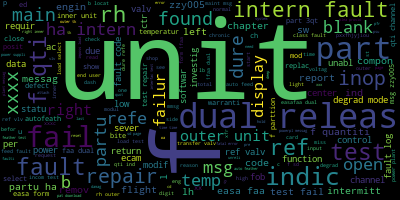

In [39]:
#Visualizing the keywords in the 'Replacement' class of Fault notification

# joining all the sentences.
corpus3=' '.join(data3[data3.Class == 'Replacement'].FN_stpw)
# generating word cloud
word_cloud=WordCloud().generate(corpus3)
img=word_cloud.to_image()
img

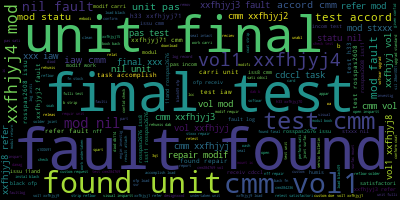

In [40]:
#Visualizing the keywords in the 'No fault found' class of Fault notification

# joining all the sentences.
corpus4=' '.join(data3[data3.Class == 'No fault found'].MA_stpw)
# generating word cloud
word_cloud=WordCloud().generate(corpus4)
img=word_cloud.to_image()
img

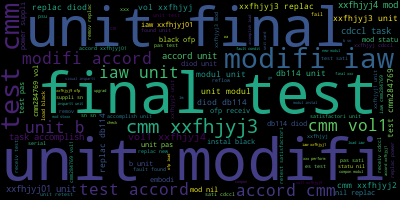

In [41]:
#Visualizing the keywords in the 'Modification' class of Fault notification

# joining all the sentences.
corpus5=' '.join(data3[data3.Class == 'Modification'].MA_stpw)
# generating word cloud
word_cloud=WordCloud().generate(corpus5)
img=word_cloud.to_image()
img

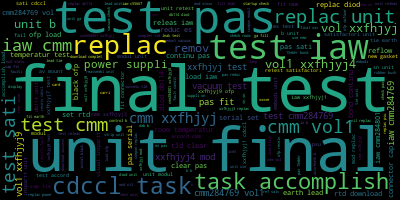

In [42]:
#Visualizing the keywords in the 'Replacement' class of Fault notification

# joining all the sentences.
corpus6=' '.join(data3[data3.Class == 'Replacement'].MA_stpw)
# generating word cloud
word_cloud=WordCloud().generate(corpus6)
img=word_cloud.to_image()
img

#### Implementing the counter to investigate the most occuring Sentences

In [43]:
#For the Maintenance Action

import collections
c = collections.Counter(data3.MA_stpw)

#Checking the number of unique words
num_unique_words =len(c)
print (num_unique_words)

c.most_common(5)

1143


[('mod 01 fault found unit final test cmm vol1 xxfhjyj4', 35),
 ('mod nil fault found unit final test cmm 284236 vol1 xxfhjyj4', 34),
 ('fault found unit final test cmm xxfhjyj3', 25),
 ('mod nil fault found unit final test cmm vol1 xxfhjyj4', 22),
 ('mod nil fault found unit final test cmm 284236 vol1 xxfhjyj4 ', 16)]

In [44]:
#For the Fault Notification

import collections
c = collections.Counter(data3.FN_stpw)

#Checking the number of unique words
num_unique_words =len(c)
print (num_unique_words)

c.most_common(5)

1349


[('reason given paperwork ', 37),
 ('reason given paperwork', 29),
 ('modif', 11),
 ('softwar upgrad', 7),
 ('indic comput softwar upgrad', 6)]

In [45]:
#https://www.youtube.com/watch?v=kxeyoyrf2cM
#For the 'No Fault Found' Class of Maintenance Action

import collections
c = collections.Counter(data3[data3.Class == 'No fault found'].MA_stpw)

#Checking the number of unique words
num_unique_words =len(c)
print (num_unique_words)

c.most_common(5)

247


[('mod 01 fault found unit final test cmm vol1 xxfhjyj4', 35),
 ('mod nil fault found unit final test cmm 284236 vol1 xxfhjyj4', 34),
 ('fault found unit final test cmm xxfhjyj3', 25),
 ('mod nil fault found unit final test cmm vol1 xxfhjyj4', 22),
 ('mod nil fault found unit final test cmm 284236 vol1 xxfhjyj4 ', 16)]

In [46]:
#For the 'No Fault Found' Class of Fault Notification

import collections
c = collections.Counter(data3[data3.Class == 'No fault found'].FN_stpw)

#Checking the number of unique words
num_unique_words =len(c)
print (num_unique_words)

c.most_common(5)

436


[('reason given paperwork ', 31),
 ('reason given paperwork', 28),
 ('stxxxd', 5),
 ('retest recertif', 2),
 ('quot paperwork dual releas', 2)]

In [47]:
#For the Modification Class of Maintenance Action

import collections
c = collections.Counter(data3[data3.Class == 'Modification'].MA_stpw)

#Checking the number of unique words
num_unique_words =len(c)
print (num_unique_words)

c.most_common(5)


421


[('replac diod db114 unit b unit modifi 50591420 50591431 iaw 505928710 xxfhjyj01 unit final test cmm xxfhjyj3',
  8),
 ('unit modifi 033001 033002 iaw 03300128490 replac new modul instal black 05 ofp receiv test cmm284769 vol 1 xxfhjyj 8 cdccl task accomplish',
  8),
 ('unit modifi 50591420 50591431 accord 505928710 unit final test accord cmm xxfhjyj3',
  8),
 ('unit modifi 50591420 50591431 iaw 505928710 unit final test cmm xxfhjyj3',
  7),
 ('unit modifi 50591420 50591431 accord 505928710 unit final test accord cmm xxfhjyj3 mod statu 01',
  5)]

In [48]:
#For the Modification Class of Fault Notification

import collections
c = collections.Counter(data3[data3.Class == 'Modification'].FN_stpw)

#Checking the number of unique words
num_unique_words =len(c)
print (num_unique_words)

c.most_common(5)


429


[('modif', 10),
 ('softwar upgrad', 7),
 ('indic comput softwar upgrad', 6),
 ('reason given paperwork ', 6),
 ('modif action dual releas', 5)]

In [49]:
#For the Replacement Class of Maintenance Action

import collections
c = collections.Counter(data3[data3.Class == 'Replacement'].MA_stpw)

#Checking the number of unique words
num_unique_words =len(c)
print (num_unique_words)

c.most_common(5)

478


[('mod 01 replac diod db114 unit b unit final test cmm vol1 xxfhjyj4', 7),
 ('mod statu 01 replac db114 diod unit modul unit final test accord cmm vol1 xxfhjyj4',
  6),
 ('psm replac unit final test iaw cmm284769 vol1 xxfhjyj9 ofp load iaw 03300128495 xxfhjyj1 cdccl task accomplish',
  4),
 ('mod 01 replac diod db114 unit b unit final test cmm vol 1 xxfhjyj 4', 3),
 ('replac db114 diod unit modul unit final test accord cmm xxfhjyj3', 3)]

In [50]:
#For the Replacement Class of Fault Notification

import collections
c = collections.Counter(data3[data.Class == 'Replacement'].FN_stpw)

#Checking the number of unique words
num_unique_words =len(c)
print (num_unique_words)

c.most_common(5)

496


[('b2093e53 partu leakag fault easa form 1faa dual releas', 2),
 ('partu ha intern fault', 2),
 ('unit purchas thru servic sale possibl b stock breakdown', 2),
 ('fail pat download dump fault log ref interfac test discret input testpow variat test flight softwar confid test power variat fail easa faa dual releas ',
  2),
 ('fg l main indic blank tt', 1)]

#### Implementing the counter to investigate the most occuring words

In [51]:
#For the No Fault Found Class of Fault Notification
import collections

#Count of unique words
def counter_word(text_col):
    count=collections.Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] +=1
    return count
counter = counter_word(data3.FN_stpw)
counter.most_common(10)

[('f', 488),
 ('unit', 395),
 ('fault', 298),
 ('releas', 266),
 ('dual', 260),
 ('test', 240),
 ('part', 223),
 ('fail', 157),
 ('indic', 131),
 ('reason', 122)]

In [52]:
#For the No Fault Found Class of Fault Notification
import collections

#Count of unique words
def counter_word(text_col):
    count=collections.Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] +=1
    return count
counter = counter_word(data3.MA_stpw)
counter.most_common(10)


[('unit', 2498),
 ('test', 2022),
 ('final', 1169),
 ('cmm', 1118),
 ('replac', 869),
 ('iaw', 771),
 ('mod', 635),
 ('fault', 611),
 ('vol1', 593),
 ('pas', 573)]

In [53]:
#For the No Fault Found Class of Fault Notification
import collections

#Count of unique words
def counter_word(text_col):
    count=collections.Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] +=1
    return count
counter1 = counter_word(data3[data3.Class == 'No fault found'].FN_stpw)


# to get the number of unique words
len(counter1)

1219

In [54]:
counter1.most_common(10)

[('f', 216),
 ('unit', 138),
 ('fault', 111),
 ('test', 88),
 ('reason', 88),
 ('paperwork', 79),
 ('part', 77),
 ('given', 69),
 ('outer', 60),
 ('releas', 57)]

In [55]:
num_unique_words = len(counter1)

In [56]:
#For the Modification Class of Fault Notification
import collections

#Count of unique words
def counter_word(text_col):
    count=collections.Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] +=1
    return count
counter2 = counter_word(data3[data3.Class == 'Modification'].FN_stpw)


# to get the number of unique words
len(counter2)

1004

In [57]:
counter2.most_common(10)

[('releas', 107),
 ('dual', 101),
 ('f', 96),
 ('unit', 87),
 ('fault', 79),
 ('upgrad', 70),
 ('part', 60),
 ('test', 59),
 ('modif', 58),
 ('fail', 47)]

In [58]:
num_unique_words = len(counter2)

In [59]:
#For the Replacement Class of Fault Notification

import collections

#Count of unique words
def counter_word(text_col):
    count=collections.Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] +=1
    return count
counter3 = counter_word(data3[data3.Class == 'Replacement'].FN_stpw)


# to get the number of unique words
len(counter3)

1303

In [60]:
counter3.most_common(10)

[('f', 176),
 ('unit', 170),
 ('fault', 108),
 ('dual', 106),
 ('releas', 102),
 ('test', 93),
 ('part', 86),
 ('fail', 83),
 ('ref', 60),
 ('indic', 49)]

In [61]:
num_unique_words = len(counter3)

In [62]:
#For the No fault Found Class of Maintenance Action

import collections

#Count of unique words
def counter_word(text_col):
    count=collections.Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] +=1
    return count
counter11 = counter_word(data3[data3.Class == 'No fault found'].MA_stpw)


# to get the number of unique words
len(counter11)

374

In [63]:
counter11.most_common(10)

[('unit', 565),
 ('test', 547),
 ('fault', 479),
 ('cmm', 452),
 ('found', 436),
 ('final', 410),
 ('mod', 313),
 ('vol1', 285),
 ('xxfhjyj4', 218),
 ('nil', 175)]

In [64]:
num_unique_words = len(counter11)

In [65]:
#For the Modification Class of Maintenance Action
import collections

#Count of unique words
def counter_word(text_col):
    count=collections.Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] +=1
    return count
counter22 = counter_word(data3[data3.Class == 'Modification'].MA_stpw)


# to get the number of unique words
len(counter22)

944

In [66]:
counter22.most_common(10)

[('unit', 1069),
 ('test', 594),
 ('modifi', 481),
 ('cmm', 390),
 ('iaw', 368),
 ('final', 366),
 ('replac', 278),
 ('accord', 270),
 ('505928710', 232),
 ('xxfhjyj3', 187)]

In [67]:
num_unique_words = len(counter22)

In [68]:
#For the Replacement Class of Maintenance Action

import collections

#Count of unique words
def counter_word(text_col):
    count=collections.Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] +=1
    return count
counter33 = counter_word(data3[data3.Class == 'Replacement'].MA_stpw)


# to get the number of unique words
len(counter33)

1455

In [69]:
counter33.most_common(10)

[('test', 881),
 ('unit', 864),
 ('replac', 589),
 ('pas', 396),
 ('final', 393),
 ('iaw', 316),
 ('cmm', 276),
 ('b', 247),
 ('xxfhjyj', 217),
 ('vol1', 171)]

In [70]:
num_unique_words = len(counter33)

##### Applying Genism for keyword extraction

In [71]:
import gensim
from gensim.summarization import keywords
text1 = ' '.join(data3[data3.Class == 'No fault found'].FN_stpw)
print ('Keywords:')
keywords(text1)[:200]

Keywords:


'fault\ntest\nunit fail left\nreleas reason\npaperwork\nindic failur dual\nplea\necam\nmsg\nref\nreturn repair\nflight\nind\nqti\nopen short remov\ninoper\npartu report\nright\nfluctuat fob\nvalv\ncentr main card dure hig'

In [72]:
import gensim
from gensim.summarization import keywords
text2 = ' '.join(data3[data3.Class == 'No fault found'].MA_stpw)
print ('Keywords:')
keywords(text2)[:100]

Keywords:


'retest unit fault\nxxx test\nxxfhjyj cmm\nnil\ncarri\nmod\nsatisfactori\nfinal\ncustom\nstrip modul\nembodi\nre'

In [73]:
import gensim
from gensim.summarization import keywords
text3 = ' '.join(data3[data3.Class == 'Replacement'].FN_stpw)
print ('Keywords:')
keywords(text3)[:100]

Keywords:


'ref\nrepair\npossibl right unit\ndure\npartu\ninop\ndual releas fatal error\nqti channel eica msg incom tes'

In [74]:
import gensim
from gensim.summarization import keywords
text4 = ' '.join(data3[data3.Class == 'Replacement'].MA_stpw)
print ('Keywords:')
keywords(text4)[:100]

Keywords:


'unit\nreplaced\ntest sati\nmodul\nxxfhjyj\nnew compon fit\npas\ndisplay bond cabl mod embodi fhxxx replac\nr'

In [75]:
import gensim
from gensim.summarization import keywords
text5 = ' '.join(data3[data3.Class == 'Modification'].FN_stpw)
print ('Keywords:')
keywords(text5)[:100]

Keywords:


'unit\nfault\nmodif\ntest maint\nmodifi\naction dual releas\nplea\nsoftwar upgrad\nremov\nunservic indic\nmod p'

In [76]:
import gensim
from gensim.summarization import keywords
text6 = ' '.join(data3[data3.Class == 'Modification'].MA_stpw)
print ('Keywords:')
keywords(text6)[:100]

Keywords:


'unit\ntest\nreplac\nmodul remov\npas\niaw\nmod\ncmm xxfhjyj\nicm modifi\nembodi\ncompon\nxxx\nreflow\nnew\npsu\nloa'

##### Applying Rake NLTK for key phrase extraction

##### Applying PyTextRank for the count of word occurance  and identification multi-phrase texts. it is an unsupervised method and is a language independent implementation of similarity measure. 

In [83]:
#For the No fault found classs of the Fault notification
import spacy
import pytextrank

text1 = ' '.join(data3[data3.Class == 'No fault found'].FN_stpw)

# load a spaCy model
nlp = spacy.load("en_core_web_sm")

# add PyTextRank to the spaCy pipeline
nlp.add_pipe("textrank")

#loading the text into the spacy model
doc = nlp(text1)

# examine the top-ranked phrases in the document
for phrase in doc._.phrases:
    print("%s %s %s"%(phrase.rank, phrase.count, phrase.text))
    

0.10193157779901402 1 test unit
0.10100668582253394 1 right outer unit right unit
0.10024052190096322 1 indic f unit
0.1002245329285964 1 paperwork paperwork unit
0.10003137985237331 3 f unit
0.09490378325704166 1 paperwork unit
0.09218705134271243 1 fault reason
0.0917713735479253 1 outer unit
0.09031883997915728 1 inner outer unit
0.08970391978974467 1 reg daizz unwant f transfer outer unit inner unit right unit
0.08871964723402198 1 paperwork stxxxd inner unit
0.08793146359838297 1 dual releas rh unit
0.08726323406391748 1 f center unit parttion
0.08627041643503647 1 outer right inner unit remov
0.08575824512676845 5 inner unit
0.08547886173102527 1 p ping test lh unit
0.08473565229189317 1 paperwork test
0.08464112468064706 1 hand outer unit
0.08369617033165902 1 right unit
0.08352817974168532 1 paperwork test class
0.08352260289555685 1 f part ch1 fault camo note
0.08343831878797453 1 right inner unit
0.08296364959280188 1 paperwork reason remov
0.0828966957792462 3 unit
0.0828873

In [84]:
#For the No fault found classs of the Matenance Action
import spacy
import pytextrank

text2 = ' '.join(data3[data3.Class == 'No fault found'].MA_stpw)

# load a spaCy model
nlp = spacy.load("en_core_web_sm")

# add PyTextRank to the spaCy pipeline
nlp.add_pipe("textrank")

#loading the text into the spacy model
doc = nlp(text2)

# examine the top-ranked phrases in the document
for phrase in doc._.phrases:
    print("%s %s %s"%(phrase.rank, phrase.count, phrase.text))
    

0.20388057554031944 2 fault found unit test
0.20219861410129908 1 unit final test cmm xxfhjyj3 unit
0.19899921627256764 4 fault found unit final test accord
0.19768879026192715 1 unit test fault
0.19747809390107757 6 unit final test cmm
0.19664756865230923 4 unit final test
0.19467793600744163 1 unit final test cmm xxfhjyj2 unit test svr rig fault
0.1942762689917981 25 unit final test cmm xxfhjyj3 fault
0.19123867089275826 1 humis unit b unit final test cmm
0.1903010336818922 1 fault found unit test iaw
0.1900741347673066 1 fault unit b unit
0.18832913839632565 1 fault found unit
0.18788979093216604 2 test cmm xxfhjyj2 unit fulli test fault
0.1872496287177662 1 fault found unit final test h33 xxfhjyj71
0.18708172392150563 2 unit final test cmm vol
0.1858895518776815 10 unit final test accord
0.1856502513637939 1 satisfactori unit final test cmm
0.18452567427870945 1 open unit final test cmm
0.18421775317452915 1 ontpid112 unit final test cmm
0.18400375710434808 1 test unit
0.1815600469

In [85]:
#For the Replacement class of the fault Notification
import spacy
import pytextrank

text3 = ' '.join(data3[data3.Class == 'Replacement'].FN_stpw)

# load a spaCy model
nlp = spacy.load("en_core_web_sm")

# add PyTextRank to the spaCy pipeline
nlp.add_pipe("textrank")

#loading the text into the spacy model
doc = nlp(text3)

# examine the top-ranked phrases in the document
for phrase in doc._.phrases:
    print("%s %s %s"%(phrase.rank, phrase.count, phrase.text))

0.12169441672545875 1 unit unit
0.11737922124795433 1 outer unit unit
0.11067821680008705 1 l outer unit unit
0.10663027140782456 1 test unit
0.1028312153401918 2 f unit
0.10071304841184739 1 part main unit
0.1002290659596041 1 valv fing sw inop part dual releas rh unit unit
0.09970793021881806 1 central unit refe control unit
0.09915526368068975 1 close dual releas ref unit
0.09798370057348021 1 f quantiti unit
0.09694963750436769 1 indic part rh unit
0.09446997195774433 2 outer unit
0.09411093874723214 1 f quantiti indic main unit
0.09301149305615818 1 attach unit chronic unit warranti remov
0.09215340088512623 1 valv xxxx dual releas unabl load test softwar unit
0.09127081254409407 4 unit
0.09109998225861644 1 f page indic f quantiti outer unit
0.09101856990878145 2 inner unit
0.09096300537168725 1 open unit
0.09009176027435296 1 cu statu dual releas center unit
0.08895527553300421 2 dual releas part
0.08863366294644413 1 fob indic unit
0.08836324411704523 3 lh unit
0.08829985614388

In [86]:
#For the Replacement class of the Maintenance Action
import spacy
import pytextrank

text4 = ' '.join(data[data.Class == 'Replacement'].MA)

# load a spaCy model
nlp = spacy.load("en_core_web_sm")

# add PyTextRank to the spaCy pipeline
nlp.add_pipe("textrank")

#loading the text into the spacy model
doc = nlp(text4)

# examine the top-ranked phrases in the document
for phrase in doc._.phrases:
    print("%s %s %s"%(phrase.rank, phrase.count, phrase.text))

0.09659669571591648 227 ###
0.09223167401684462 3 REPLACED unit
0.08794099669024848 1 Replaced unit B B
0.08744309769180598 1 Replaced unit
0.08629170686249801 1 REPLACED S R221
0.08586372952525909 2 ##
0.08512642308527696 1 unit LAMP REPLACED
0.08424897575456027 1 Replaced unit B module
0.08366209908392017 2 FITTED NEW unit
0.08183631732858412 1 Unit Final Tested IAW CMM
0.08182857242378146 1 Replaced front unit
0.08068327145781706 1 NEW unit
0.0805111963118664 1 FITTED unit
0.0796350774724366 1 EMBODIED.THREE unit LAMPS REPLACED
0.07962302266918343 1 Unit final tested I.A.W CMM28
0.07954405460202482 1 REPLACED RIGHT MAIN unit DISPLAY B. REPLACED U4
0.07926987288120169 1 Unit final tested IAW ROS.S.PAS.2676
0.07892089657323538 1 Unit final tested iaw Cmm28
0.07827017822112346 1 NEW PSU S
0.07730842969484157 1 NEW CHASSIS S
0.07634657023015107 4 unit B module
0.07630516648291685 1 unit xxxxES S3,THRU S10 REPLACED
0.07629646844325252 5 unit B
0.0757429147626138 1 new front unit
0.074774

In [87]:
#For the Modification of the Maintenance Action
import spacy
import pytextrank

text5 = ' '.join(data3[data3.Class == 'Modification'].MA_stpw)

# load a spaCy model
nlp = spacy.load("en_core_web_sm")

#initailising pytextrank

# add PyTextRank to the spaCy pipeline
nlp.add_pipe("textrank")

#loading the text into the spacy model
doc = nlp(text5)

# examine the top-ranked phrases in the document
for phrase in doc._.phrases:
    print("%s %s %s"%(phrase.rank, phrase.count, phrase.text))

0.18908942242029697 1 unit pas test sati unit
0.18721211354891715 1 modul replac unit modul unit
0.18418536456645526 1 replac db114 unit modul unit
0.1809953690090737 1 test replac diod db114 unit b unit
0.17824585352313202 1 ic10 unit b unit modifi
0.1774706669885409 1 unit retest satisfactori unit
0.17630075544409687 9 replac db114 diod unit modul unit
0.1759234017062988 1 final test cmm xxfhjyj3 db114 diod replac unit modul unit
0.1759234017062988 2 final test cmm xxfhjyj3 replac db114 diod unit modul unit
0.17510567761669993 1 proper function unit unit modifi
0.17143704639533902 1 final test unit accord
0.17110457309453106 1 final test accord cmm xxfhjyj3 db114 diod replac unit modul unit modifi
0.16882013601197612 1 unit pas test sati visual inspartt unit
0.16642621163896246 1 cmm xxfhjyj3 replac db114 diod unit modul unit
0.16560905619797364 8 modifi unit
0.16560905619797364 20 unit modifi
0.1645302494757619 1 final test accord cmm xxfhjyj3 modifi unit
0.1638298656749499 2 cmm xx

In [88]:
#For the Modification of the Fault Nitification
import spacy
import pytextrank

text6 = ' '.join(data3[data3.Class == 'Modification'].FN_stpw)

# load a spaCy model
nlp = spacy.load("en_core_web_sm")

# add PyTextRank to the spaCy pipeline
nlp.add_pipe("textrank")

#loading the text into the spacy model
doc = nlp(text6)

# examine the top-ranked phrases in the document
for phrase in doc._.phrases:
    print("%s %s %s"%(phrase.rank, phrase.count, phrase.text))

0.12125285823129311 1 dual releas dual releas right unit unit
0.10880532211563584 1 dual releas modif dual releas
0.10530220816372252 1 dual releas thi unit
0.1034985255784807 1 dual releas mod action dual releas
0.09815176283424051 1 fault unit
0.09798734356485041 1 repeat fault dual releas
0.09743444967343995 1 dual releas repair
0.09600974669910911 9 dual releas
0.09535753315083256 3 dual releas modifi
0.09356711120215618 1 fail oper due part upgrad bx1504 dual releas modif action dual releas
0.09334537884007428 1 temp indic dual releas part ch1 fault
0.09278762382191662 1 1faa dual releas fault fault code 274a234ab
0.09233324991662625 1 dual releas test releas iaw lxxxst cmm
0.09219080249098438 1 dual releas softwar
0.0908709941964244 1 dual releas modif part move degrad mode
0.08959422407224672 1 b dual releas
0.08924718583619085 1 3qt modif unit pas test xxxc unit
0.08921838206243395 1 dual releas ctr
0.08899928052109243 1 dual releas modif 777280066modif
0.08895838365899603 1 up

#### Grouping and splitting the dataset by the classes to create three sub dataframes

In [90]:
df_mod=data3[data3['Class']=='Modification']
df_mod.head(2)

,MA_stpw,FN_stpw,Class
26,xxx perform fail p interfac bite lm rm cm l r ...,ind blank intern fail hard,Modification
34,icm modifi 17623 iaw 03300128494 compon replac...,doe trsmit ani frequencynot valid reason retur...,Modification


In [91]:
df_no_flt=data3[data3['Class']=='Modification']
df_no_flt.shape

(500, 3)

In [92]:
df_rep=data3[data3['Class']=='Modification']
df_rep.shape

(500, 3)

#### Dropping the column not needed

In [93]:
df_mod.drop(['Class'], axis=1, inplace=True)
df_mod.head(2)

,MA_stpw,FN_stpw
26,xxx perform fail p interfac bite lm rm cm l r ...,ind blank intern fail hard
34,icm modifi 17623 iaw 03300128494 compon replac...,doe trsmit ani frequencynot valid reason retur...


In [94]:
df_no_flt.drop(['Class'], axis=1, inplace=True)

In [95]:
df_rep.drop(['Class'], axis=1, inplace=True)

### Similarity measure.

##### Finding the similarity score using the cosine similarity measure for the entire maintenance action and the fault notification documents

In [96]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  

# Initialize an instance of tf-idf Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Generate the tf-idf vectors for the documents
tfidf_matrix = tfidf_vectorizer.fit_transform(data3.FN_stpw,data3.MA_stpw)

# compute and print the cosine similarity matrix
cosine = cosine_similarity(tfidf_matrix[0], tfidf_matrix[1])
print (cosine)
print (tfidf_matrix)

[[0.07065904]]
  (0, 2294)	0.5364014864122006
  (0, 624)	0.40449758975950234
  (0, 1315)	0.2801600006021098
  (0, 1488)	0.37003202826476733
  (0, 1097)	0.5772710086037782
  (1, 2227)	0.126622343382352
  (1, 2303)	0.2287849855114481
  (1, 2028)	0.2406625884626789
  (1, 966)	0.2481901449857286
  (1, 1767)	0.45256392263853024
  (1, 2218)	0.16500033110795215
  (1, 1253)	0.22628196131926512
  (1, 953)	0.16784885735431618
  (1, 682)	0.22392204733808774
  (1, 698)	0.2287849855114481
  (1, 1998)	0.18257498655191107
  (1, 2142)	0.5148062591745401
  (1, 1438)	0.183426300311035
  (1, 1051)	0.13721630135149795
  (1, 2316)	0.10445929931070948
  (1, 1488)	0.1909538568340847
  (2, 2448)	0.4523333612765612
  (2, 776)	0.28964923381542
  (2, 2227)	0.18203539342416758
  (2, 2028)	0.3459824530414447
  :	:
  (1495, 2389)	0.5258454984223124
  (1495, 1950)	0.3814160360744135
  (1495, 2227)	0.3237251740042349
  (1495, 1051)	0.3508098953523419
  (1496, 1929)	0.562505418544636
  (1496, 1341)	0.3680998763639388


### Performing similarity measure for the documents split by class

##### Similarity between the Modification class of the Fault Notification and the Maintenance Action documents

In [97]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  

# Initialize an instance of tf-idf Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Generate the tf-idf vectors for the documents
tfidf_matrix = tfidf_vectorizer.fit_transform(df_mod.FN_stpw,df_mod.MA_stpw)

# compute and print the cosine similarity matrix
cosine = cosine_similarity(tfidf_matrix[0], tfidf_matrix[1])
print (cosine)
print (tfidf_matrix)

[[0.]]
  (0, 467)	0.5525867423661376
  (0, 390)	0.2888482406013075
  (0, 530)	0.37644217834622384
  (0, 214)	0.49387188769283297
  (0, 505)	0.4749699263862677
  (1, 272)	0.2804549803918532
  (1, 571)	0.19998291040323396
  (1, 13)	0.2804549803918532
  (1, 478)	0.19679687824905592
  (1, 17)	0.2804549803918532
  (1, 8)	0.20716485952092956
  (1, 601)	0.1538683664148797
  (1, 862)	0.25065536314877174
  (1, 694)	0.26302332176880705
  (1, 785)	0.19998291040323396
  (1, 784)	0.20342408728264413
  (1, 738)	0.16699726100597445
  (1, 937)	0.2804549803918532
  (1, 436)	0.2804549803918532
  (1, 179)	0.25065536314877174
  (1, 908)	0.2804549803918532
  (1, 342)	0.2804549803918532
  (2, 885)	0.2506892420976625
  (2, 499)	0.4612974558002915
  (2, 72)	0.4396061935711557
  :	:
  (495, 262)	0.5743551317641614
  (495, 761)	0.37503108039647476
  (495, 885)	0.3405654554504071
  (495, 390)	0.34928836558694315
  (496, 818)	0.6208925145335404
  (496, 517)	0.39266463057591927
  (496, 753)	0.5823009860827666
  (4

##### Similarity between the no-fault-found class of the Fault Notification and the Maintenance Action documents

In [98]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  

# Initialize an instance of tf-idf Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Generate the tf-idf vectors for the documents
tfidf_matrix = tfidf_vectorizer.fit_transform(df_no_flt.FN_stpw,df_no_flt.MA_stpw)

# compute and print the cosine similarity matrix
cosine = cosine_similarity(tfidf_matrix[0], tfidf_matrix[1])
print (cosine)
print (tfidf_matrix)

[[0.]]
  (0, 467)	0.5525867423661376
  (0, 390)	0.2888482406013075
  (0, 530)	0.37644217834622384
  (0, 214)	0.49387188769283297
  (0, 505)	0.4749699263862677
  (1, 272)	0.2804549803918532
  (1, 571)	0.19998291040323396
  (1, 13)	0.2804549803918532
  (1, 478)	0.19679687824905592
  (1, 17)	0.2804549803918532
  (1, 8)	0.20716485952092956
  (1, 601)	0.1538683664148797
  (1, 862)	0.25065536314877174
  (1, 694)	0.26302332176880705
  (1, 785)	0.19998291040323396
  (1, 784)	0.20342408728264413
  (1, 738)	0.16699726100597445
  (1, 937)	0.2804549803918532
  (1, 436)	0.2804549803918532
  (1, 179)	0.25065536314877174
  (1, 908)	0.2804549803918532
  (1, 342)	0.2804549803918532
  (2, 885)	0.2506892420976625
  (2, 499)	0.4612974558002915
  (2, 72)	0.4396061935711557
  :	:
  (495, 262)	0.5743551317641614
  (495, 761)	0.37503108039647476
  (495, 885)	0.3405654554504071
  (495, 390)	0.34928836558694315
  (496, 818)	0.6208925145335404
  (496, 517)	0.39266463057591927
  (496, 753)	0.5823009860827666
  (4

##### Similarity between the Replacement class of the Fault Notification and the Maintenance Action documents

In [99]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  

# Initialize an instance of tf-idf Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Generate the tf-idf vectors for the documents
tfidf_matrix = tfidf_vectorizer.fit_transform(df_rep.FN_stpw,df_rep.MA_stpw)

# compute and print the cosine similarity matrix
cosine = cosine_similarity(tfidf_matrix[0], tfidf_matrix[1])
print (cosine)
print (tfidf_matrix)

[[0.]]
  (0, 467)	0.5525867423661376
  (0, 390)	0.2888482406013075
  (0, 530)	0.37644217834622384
  (0, 214)	0.49387188769283297
  (0, 505)	0.4749699263862677
  (1, 272)	0.2804549803918532
  (1, 571)	0.19998291040323396
  (1, 13)	0.2804549803918532
  (1, 478)	0.19679687824905592
  (1, 17)	0.2804549803918532
  (1, 8)	0.20716485952092956
  (1, 601)	0.1538683664148797
  (1, 862)	0.25065536314877174
  (1, 694)	0.26302332176880705
  (1, 785)	0.19998291040323396
  (1, 784)	0.20342408728264413
  (1, 738)	0.16699726100597445
  (1, 937)	0.2804549803918532
  (1, 436)	0.2804549803918532
  (1, 179)	0.25065536314877174
  (1, 908)	0.2804549803918532
  (1, 342)	0.2804549803918532
  (2, 885)	0.2506892420976625
  (2, 499)	0.4612974558002915
  (2, 72)	0.4396061935711557
  :	:
  (495, 262)	0.5743551317641614
  (495, 761)	0.37503108039647476
  (495, 885)	0.3405654554504071
  (495, 390)	0.34928836558694315
  (496, 818)	0.6208925145335404
  (496, 517)	0.39266463057591927
  (496, 753)	0.5823009860827666
  (4

In [100]:
#The five steps in the Deep learning process flow are as follows:

#Define the model.
#Compile the model.
#Fit the model.
#Evaluate the model.
#Make predictions.

In [101]:
#Confirming the balance in the dataset

print((data3.Class =='Replacement').sum()) # Replacement Class
print((data3.Class =='No fault found').sum()) # No fault found Class
print((data3.Class =='Modification').sum()) #Modification Class


500
500
500


In [102]:
data3=data3.astype('string')
data3.dtypes

MA_stpw    string
FN_stpw    string
Class      string
dtype: object

### Label Encoding

In [103]:
x=(data3['FN_stpw'])
x2=(data3['MA_stpw'])

In [104]:
#Applying the label encoding as the onehot encoding was not supported this Bert model used in this study
label = {'No fault found':0, 'Replacement':1, 'Modification':2}
data3["Class"].replace(label, inplace=True)


In [105]:
#Splitting fault notification document into training and testing with Sklearn
x=data3['FN_stpw']
x_train, x_test= train_test_split(data3['FN_stpw'], test_size=0.2,stratify=data3['Class'], shuffle=True)


In [106]:
#Splitting the maintenance action document into training and testing with Sklearn
x2=data3['MA_stpw']
y=data2['Class']
x2_train, x2_test, y_train, y_test = train_test_split(data3['MA_stpw'], data3['Class'],test_size=0.2,stratify=data3['Class'], shuffle=True)


In [107]:
x_train.head(2)

100              reason given paperwork 
927    upgrad easa form 1faa dual releas
Name: FN_stpw, dtype: string

In [108]:
x2_train.head(2)

576     mod stxxx nil unit modifi 50591331 iaw 5059287...
1068    mod nil replac diod db114 unit b unit modifi 5...
Name: MA_stpw, dtype: string

In [109]:
#data3.astype('float32').dtypes
print(x_train.shape)
print(y_train.shape)

(1200,)
(1200,)


In [110]:
print(x2_train.shape)
print(y_train.shape)

(1200,)
(1200,)


In [111]:
x_test[:20]

1015                             pn033001 modifi pn033002
108                         transfert vlv stay close time
907                                        modif 50591431
719                                mod action dual releas
688                                              teardown
792                                 sw upgrad dual releas
1282    free charg function test acc lastest manufactu...
1299    mod 777280066 mod pre mod pn 033001 post mod p...
1096          shelf life expiri funtion check dual releas
580                                             sw upgrad
43      remov part comput replac due recertif meet lr ...
1375            rh engin part inb aft isol mount deterior
1333                            auto feed fault dure refe
1432                            smooth rh ref vlv sw part
1427                    part display fail msg display mat
1350                   part total backup ind1 tf ind inop
145                                reason given paperwork
587           

In [112]:
x2_test[:20]

1287    replac diod db114 unit b unit retest satisfact...
49      inspartt unit show ha suffer sever mechan shoc...
1307    replac logic b u21 rm led reflow suspartt dryp...
1193             psu replac unit final test cmm xxfhjyj 3
1110    mod nil unit modifi 50591320 50591331 accord 5...
697     mod 01 02 replac unit b b unit test rosspas260...
209     mod nil fault found unit final test cmm 284236...
632     mod statu nil fault found unit final test acco...
1217    remov 400pc040020 sn am3908098948 replac 400pc...
1255    replac psu 406752075 sn 817 psu 406752075 sn s...
1341    replac r221 r233 r245 r321 r333 r345 unit rete...
1177    power suppli sn516 replac sn1176 test cmm28476...
174     mod 01 replac r304 theghjjffb unit final test ...
679      modifi 50591320 iaw 505928479 test cmm xxfhjyj2 
488                    unit test satisfactori fault found
1160    new logic b fit unit final test iaw cmm 284801...
722     remov modul chassi unit chassi 17604 snk0070 r...
1051    mod 01

## Building Diverse Classifiers Models for Both Features 

### Multinomial Naive Bayes Classifier 

accuracy 0.36666666666666664
                precision    recall  f1-score   support

No fault found       0.39      0.33      0.36       100
   Replacement       0.36      0.36      0.36       100
  Modification       0.36      0.41      0.38       100

      accuracy                           0.37       300
     macro avg       0.37      0.37      0.37       300
  weighted avg       0.37      0.37      0.37       300



Text(0.5, 15.0, 'Predicted label')

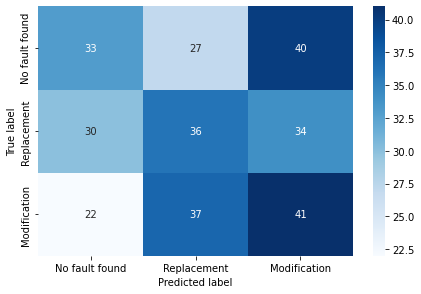

In [113]:
#For Fault Notification
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score, confusion_matrix
Class=['No fault found','Replacement','Modification']
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])

nb.fit(x_train, y_train)

from sklearn.metrics import classification_report
y_pred_fn = nb.predict(x_test)

print('accuracy %s' % accuracy_score(y_pred_fn, y_test))
print(classification_report(y_test, y_pred_fn,target_names=Class))

#Creating the confusion matrix
cm_nb = confusion_matrix(y_test,y_pred_fn)

# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_nb_df = pd.DataFrame(cm_nb)
                     
sns.heatmap(data=cm_nb_df, annot=True,fmt='g', cmap=plt.cm.Blues, xticklabels=Class,yticklabels=Class)
            
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

accuracy 0.8033333333333333
                precision    recall  f1-score   support

No fault found       0.82      0.96      0.88       100
   Replacement       0.80      0.66      0.73       100
  Modification       0.78      0.79      0.79       100

      accuracy                           0.80       300
     macro avg       0.80      0.80      0.80       300
  weighted avg       0.80      0.80      0.80       300



Text(0.5, 15.0, 'Predicted label')

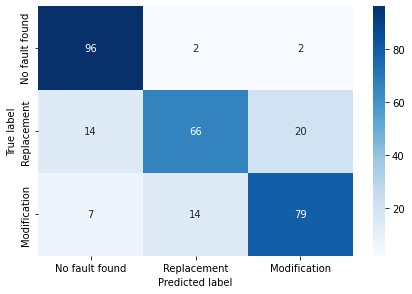

In [114]:
#For Maintenance Action

from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score, confusion_matrix
Class=['No fault found','Replacement','Modification']

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(x2_train, y_train)

from sklearn.metrics import classification_report
y_pred_ma = nb.predict(x2_test)

print('accuracy %s' % accuracy_score(y_pred_ma, y_test))
print(classification_report(y_test, y_pred_ma,target_names=Class))


#Creating the confusion matrix
cm_nb2 = confusion_matrix(y_test,y_pred_ma)

# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_nb2_df = pd.DataFrame(cm_nb2)
                     
sns.heatmap(data=cm_nb2_df, annot=True,fmt='g', cmap=plt.cm.Blues, xticklabels=Class,yticklabels=Class)
            
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

##### The results show that Naive Bayes classifier can predict Fault Notification with 32% accuracy and 85% for Maintenance Action.

### Logistic Regression

accuracy 0.32666666666666666
                precision    recall  f1-score   support

No fault found       0.34      0.26      0.30       100
   Replacement       0.33      0.37      0.35       100
  Modification       0.31      0.35      0.33       100

      accuracy                           0.33       300
     macro avg       0.33      0.33      0.32       300
  weighted avg       0.33      0.33      0.32       300



Text(0.5, 15.0, 'Predicted label')

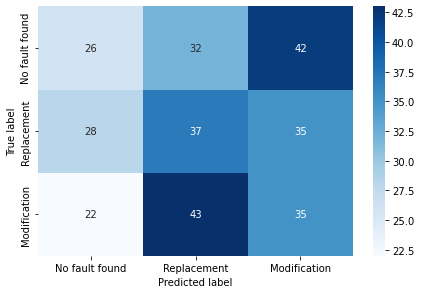

In [115]:
#For Fault Notification

from sklearn.linear_model import LogisticRegression
Class=['No fault found','Replacement','Modification']
logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(x_train, y_train)

y_pred_lr = logreg.predict(x_test)

print('accuracy %s' % accuracy_score(y_pred_lr, y_test))
print(classification_report(y_test, y_pred_lr,target_names=Class))

#Creating the confusion matrix
cm_lr = confusion_matrix(y_test,y_pred_lr)

# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_lr_df = pd.DataFrame(cm_lr)
                     
sns.heatmap(data=cm_lr_df, annot=True,fmt='g', cmap=plt.cm.Blues, xticklabels=Class,yticklabels=Class)
            
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

accuracy 0.9433333333333334
                precision    recall  f1-score   support

No fault found       0.96      0.98      0.97       100
   Replacement       0.92      0.93      0.93       100
  Modification       0.95      0.92      0.93       100

      accuracy                           0.94       300
     macro avg       0.94      0.94      0.94       300
  weighted avg       0.94      0.94      0.94       300



Text(0.5, 15.0, 'Predicted label')

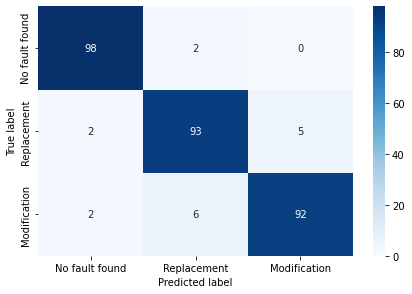

In [116]:
#For Maintenance Action

from sklearn.linear_model import LogisticRegression
Class=['No fault found','Replacement','Modification']
logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(x2_train, y_train)

y_pred_lr2 = logreg.predict(x2_test)

print('accuracy %s' % accuracy_score(y_pred_lr2, y_test))
print(classification_report(y_test, y_pred_lr2,target_names=Class))



#Creating the confusion matrix
cm_lr2 = confusion_matrix(y_test,y_pred_lr2)

# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_lr2_df = pd.DataFrame(cm_lr2)
                     
sns.heatmap(data=cm_lr2_df, annot=True,fmt='g', cmap=plt.cm.Blues, xticklabels=Class,yticklabels=Class)
            
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

##### The Logistic Regression Classifier shows same result as the Naive Bayes classification for the Fault Notification at 32% while Maintenance Action improved to 92%  for model accuracy 

#### Applying Stochastic Gradient Descent  - Linear Support Vector Machine Classifier

accuracy 0.33
                precision    recall  f1-score   support

No fault found       0.35      0.30      0.32       100
   Replacement       0.31      0.35      0.33       100
  Modification       0.33      0.34      0.33       100

      accuracy                           0.33       300
     macro avg       0.33      0.33      0.33       300
  weighted avg       0.33      0.33      0.33       300



Text(0.5, 15.0, 'Predicted label')

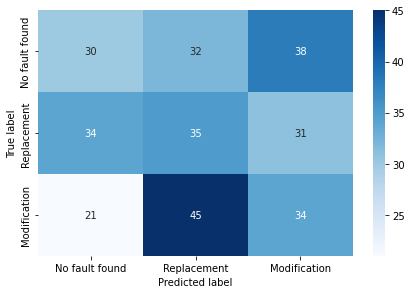

In [117]:
#For Fault Notification

from sklearn.linear_model import SGDClassifier
Class=['No fault found','Replacement','Modification']
sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])

sgd.fit(x_train, y_train)

y_pred_sgd = sgd.predict(x_test)

print('accuracy %s' % accuracy_score(y_pred_sgd, y_test))
print(classification_report(y_test, y_pred_sgd,target_names=Class))

#Creating the confusion matrix
cm_sv = confusion_matrix(y_test, y_pred_sgd)

# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_sv_df = pd.DataFrame(cm_sv)
                     
sns.heatmap(data=cm_sv_df, annot=True,fmt='g', cmap=plt.cm.Blues, xticklabels=Class,yticklabels=Class)
            
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

accuracy 0.9433333333333334
                precision    recall  f1-score   support

No fault found       0.99      0.99      0.99       100
   Replacement       0.90      0.94      0.92       100
  Modification       0.95      0.90      0.92       100

      accuracy                           0.94       300
     macro avg       0.94      0.94      0.94       300
  weighted avg       0.94      0.94      0.94       300



Text(0.5, 15.0, 'Predicted label')

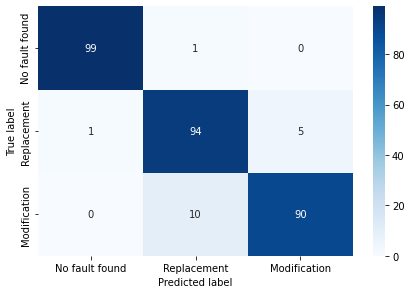

In [118]:
# For Maintenance Action
from sklearn.linear_model import SGDClassifier
Class=['No fault found','Replacement','Modification']
sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(x2_train, y_train)

y_pred_sgd1 = sgd.predict(x2_test)

print('accuracy %s' % accuracy_score(y_pred_sgd1, y_test))
print(classification_report(y_test, y_pred_sgd1,target_names=Class))

cm_sv2 = confusion_matrix(y_test, y_pred_sgd1)


# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_sv2_df = pd.DataFrame(cm_sv2)
                     
sns.heatmap(data=cm_sv2_df, annot=True,fmt='g', cmap=plt.cm.Blues, xticklabels=Class,yticklabels=Class)
            
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')


### Applying Decision Tree Classifier

accuracy 0.3433333333333333
                precision    recall  f1-score   support

No fault found       0.29      0.02      0.04       100
   Replacement       1.00      0.02      0.04       100
  Modification       0.34      0.99      0.51       100

      accuracy                           0.34       300
     macro avg       0.54      0.34      0.19       300
  weighted avg       0.54      0.34      0.19       300



Text(0.5, 15.0, 'Predicted label')

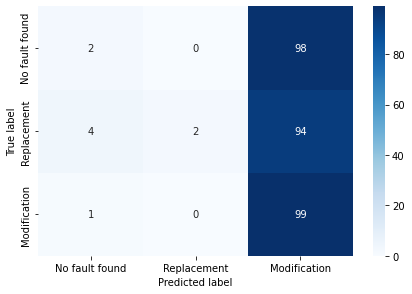

In [119]:
#For Fault Notification
from sklearn.tree import DecisionTreeClassifier
Class=['No fault found','Replacement','Modification']

#DT= DecisionTreeClassifier(criterion='entropy',max_depth=3, random_state=42)
#classifier.fit(x_train, y_train)
DT = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', DecisionTreeClassifier(criterion='entropy',max_depth=3, random_state=42))])  #loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None,)),])

DT.fit(x_train, y_train)

y_pred_DT = DT.predict(x_test)

print('accuracy %s' % accuracy_score(y_pred_DT, y_test))
print(classification_report(y_test, y_pred_DT,target_names=Class))

#Creating the confusion matrix
cm_DT = confusion_matrix(y_test, y_pred_DT)

# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_DT_df = pd.DataFrame(cm_DT)
                     
sns.heatmap(data=cm_DT_df, annot=True,fmt='g', cmap=plt.cm.Blues, xticklabels=Class,yticklabels=Class)
            
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

accuracy 0.8833333333333333
                precision    recall  f1-score   support

No fault found       0.81      0.99      0.89       100
   Replacement       0.92      0.82      0.87       100
  Modification       0.94      0.84      0.89       100

      accuracy                           0.88       300
     macro avg       0.89      0.88      0.88       300
  weighted avg       0.89      0.88      0.88       300



Text(0.5, 15.0, 'Predicted label')

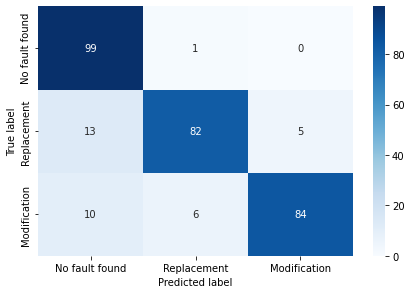

In [120]:
#For Maintenance Action
from sklearn.tree import DecisionTreeClassifier
Class=['No fault found','Replacement','Modification']

#DT= DecisionTreeClassifier(criterion='entropy',max_depth=3, random_state=42)
#classifier.fit(x_train, y_train)
DT = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', DecisionTreeClassifier(criterion='entropy',max_depth=3, random_state=42))])

DT.fit(x2_train, y_train)

y_pred_DT2 = DT.predict(x2_test)

print('accuracy %s' % accuracy_score(y_pred_DT2, y_test))
print(classification_report(y_test, y_pred_DT2,target_names=Class))

#Creating the confusion matrix
cm_DT2 = confusion_matrix(y_test, y_pred_DT2)
#cm_sv = tf.math.confusion_matrix(y_test, y_pred_sgd1).numpy()


# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_DT2_df = pd.DataFrame(cm_DT2)
                     
sns.heatmap(data=cm_DT2_df, annot=True,fmt='g', cmap=plt.cm.Blues, xticklabels=Class,yticklabels=Class)
            
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

### Applying the Random Forest Classifier

accuracy 0.3466666666666667
                precision    recall  f1-score   support

No fault found       0.37      0.25      0.30       100
   Replacement       0.33      0.30      0.31       100
  Modification       0.35      0.49      0.40       100

      accuracy                           0.35       300
     macro avg       0.35      0.35      0.34       300
  weighted avg       0.35      0.35      0.34       300



Text(0.5, 15.0, 'Predicted label')

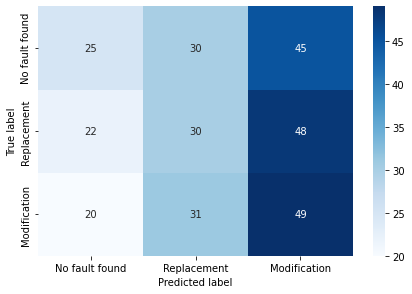

In [121]:
#For Fault Notification

from sklearn.ensemble import RandomForestClassifier
Class=['No fault found','Replacement','Modification']
#classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
RF = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier(criterion='entropy',max_depth=3, random_state=42))])

RF.fit(x_train, y_train)

y_pred_RF = RF.predict(x_test)

print('accuracy %s' % accuracy_score(y_pred_RF, y_test))
print(classification_report(y_test, y_pred_RF,target_names=Class))

#Creating the confusion matrix
cm_RF = confusion_matrix(y_test, y_pred_RF)
#cm_sv = tf.math.confusion_matrix(y_test, y_pred_sgd1).numpy()


# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_RF_df = pd.DataFrame(cm_RF)
                     
sns.heatmap(data=cm_RF_df, annot=True,fmt='g', cmap=plt.cm.Blues, xticklabels=Class,yticklabels=Class)
            
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

accuracy 0.8933333333333333
                precision    recall  f1-score   support

No fault found       0.99      0.93      0.96       100
   Replacement       0.78      0.96      0.86       100
  Modification       0.95      0.79      0.86       100

      accuracy                           0.89       300
     macro avg       0.91      0.89      0.89       300
  weighted avg       0.91      0.89      0.89       300



Text(0.5, 15.0, 'Predicted label')

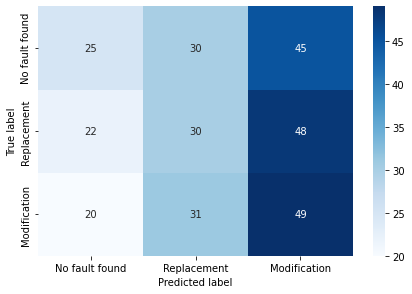

In [122]:
#For Maintenance Action

from sklearn.ensemble import RandomForestClassifier
Class=['No fault found','Replacement','Modification']
#classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
RF = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier(criterion='entropy',max_depth=3, random_state=42))])

RF.fit(x2_train, y_train)

y_pred_RF2 = RF.predict(x2_test)

print('accuracy %s' % accuracy_score(y_pred_RF2, y_test))
print(classification_report(y_test, y_pred_RF2,target_names=Class))

#Creating the confusion matrix
cm_RF2 = confusion_matrix(y_test, y_pred_RF)

# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_RF_df2 = pd.DataFrame(cm_RF2)
                     
sns.heatmap(data=cm_RF_df2, annot=True,fmt='g', cmap=plt.cm.Blues, xticklabels=Class,yticklabels=Class)
            
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

##### For the prediction of expert action using the traditional classifiers, Multinomial Naive Bayes did slightly better than its counterparts by achieving a training accuracy of 37%, while for the maintenance action document, logistic Regression and the Stochastic Gradient Classifier (SGC) both achieved 94% level of accuracy.

### Building the Text Classifier Model for Both Features using Bert (Bidirectional Encoder Representations from Transformers)

In [123]:
import tensorflow as tf
import math
import tensorflow_hub as hub
import tensorflow_text as text
from keras.models import Sequential, Model
from keras.layers import Dense, Input
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import layers


##### The functional model is being implemented because it is flexible, the input for the layer as a function was the "pooled output" prevent overfitting, 10% of the neurons used for dropout, a softmax activation function was applied since the target label is multi-classed

In [124]:
#MODEL_NAME = 'bert-base-uncased'
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'


# -- Creating the functional model cause of its robust and flexibility 
def bert_text_classification():

    # - text input -
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='Text')
        
    # - preprocessing layer - 
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
     
    # - encoding - 
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
        
    # - output -
    outputs = encoder(encoder_inputs)
# - classifier layer -

    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Dense(3, activation='softmax', name='classifier')(net)
    
    #Construct Final Model
    model = tf.keras.Model(inputs=[text_input], outputs=[net])
    return model
        
model = bert_text_classification()

model.summary()

#Input(shape=(train_ma.shape[1],))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_type_ids':   0           ['Text[0][0]']                   
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

##### The model summary shows the total parameters of 28,765,188 present in the model with more more than 99% of them being trainable.

#### Implementing Bert For Fault Notification Feature

Training Accuracy: 0.3333
Testing Accuracy:  0.3333


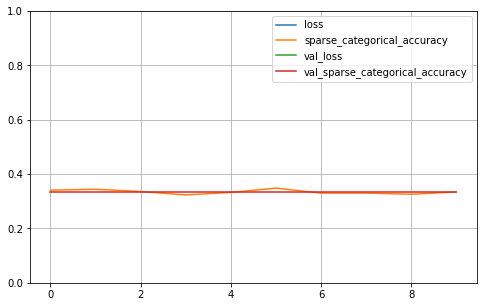

In [125]:

#For FaultNotification

model.compile(optimizer='adam', loss= tf.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=[tf.metrics.SparseCategoricalAccuracy()])
     

history = model.fit(x_train, y_train, epochs=10,verbose=False, validation_data=(x_test, y_test), batch_size=10)

loss, accuracy = model.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))


import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [127]:
y_predicted=model.predict
y_predicted =np.argmax(model.predict(x_test[:10]), axis=-1)
y_predicted

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

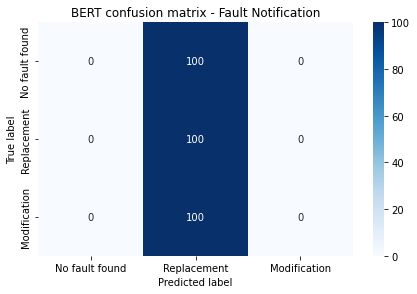

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.33      0.50       300
           2       0.00      0.00      0.00         0

    accuracy                           0.33       300
   macro avg       0.33      0.11      0.17       300
weighted avg       1.00      0.33      0.50       300



In [128]:
# -- Confusion matrix -- 
Class=['No fault found','Replacement','Modification']
y_pred = tf.nn.softmax(model.predict(x_test))

plt.title('BERT confusion matrix - Fault Notification')

# Convert the one-hot vectors to labels
y_train_labels = tf.math.argmax(y_pred, axis=1)

cm_train = tf.math.confusion_matrix(y_test, y_train_labels).numpy()
#cm_train = tf.math.confusion_matrix(y_test, y_train).numpy()

# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm_train)
                     
sns.heatmap(data=cm_df, annot=True,fmt='g', cmap=plt.cm.Blues, xticklabels=Class,yticklabels=Class)
            
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(classification_report(y_train_labels, y_test))


#### Implementing Bert For Maintenance Action Feature

Epoch 1/10
38/38 [==============================] - 347s 9s/step - loss: 1.1821 - accuracy: 0.3333 - val_loss: 1.1013 - val_accuracy: 0.3333
Epoch 2/10
38/38 [==============================] - 343s 9s/step - loss: 1.1499 - accuracy: 0.3400 - val_loss: 1.1346 - val_accuracy: 0.3333
Epoch 3/10
38/38 [==============================] - 330s 9s/step - loss: 1.1857 - accuracy: 0.3133 - val_loss: 1.1171 - val_accuracy: 0.3333
Epoch 4/10
38/38 [==============================] - 309s 8s/step - loss: 1.1754 - accuracy: 0.3242 - val_loss: 1.1337 - val_accuracy: 0.3333
Epoch 5/10
38/38 [==============================] - 301s 8s/step - loss: 1.2007 - accuracy: 0.3158 - val_loss: 1.1246 - val_accuracy: 0.3333
Epoch 6/10
38/38 [==============================] - 375s 10s/step - loss: 1.1713 - accuracy: 0.3192 - val_loss: 1.1008 - val_accuracy: 0.3333
Epoch 7/10
38/38 [==============================] - 358s 9s/step - loss: 1.1621 - accuracy: 0.3467 - val_loss: 1.1039 - val_accuracy: 0.3333
Epoch 8/10
3

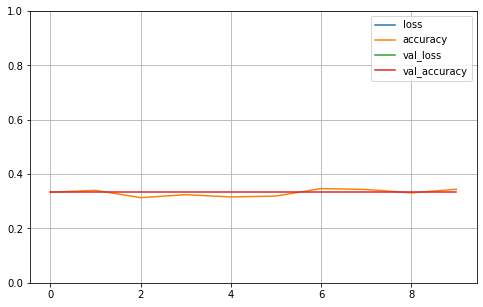

In [129]:

model.compile(optimizer='adam', loss= tf.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=[tf.metrics.SparseCategoricalAccuracy(name='accuracy')])
     
history=model.fit(x2_train, y_train, epochs=10,  validation_data=(x2_test, y_test))

loss, accuracy = model.evaluate(x2_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x2_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))


import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

##### 10 epochs were ran and a validation accuracy of 33% was achieved for Fault Notification and Maintenance Action

##### The Adam optimizer is being applied to reduce the errors during the model training, the loss function is sparsecategoricategorical entropy and the activation funtion in the output layer is softmax because this is a multi-class classification. The  metrics is also sparsecategorical entropy. 

In [131]:
#making prediction for the first 10 samples from the fault notification test set

y_predicted= model.predict(x_test[:10])
y_predicted

array([[0.23701689, 0.27573216, 0.48725095],
       [0.23701686, 0.27573213, 0.48725095],
       [0.23701687, 0.27573222, 0.48725095],
       [0.23701683, 0.27573213, 0.487251  ],
       [0.23701683, 0.27573216, 0.487251  ],
       [0.23701683, 0.27573213, 0.48725095],
       [0.2370168 , 0.27573216, 0.48725095],
       [0.23701687, 0.2757321 , 0.48725095],
       [0.23701683, 0.27573216, 0.48725095],
       [0.23701681, 0.27573213, 0.48725107]], dtype=float32)

In [132]:
# Making prediction with the first 10 from the MAintenance Action text set.
x_new = x2_test[:10]
y_proba = model.predict(x_new)
y_proba.round(2)



array([[0.24, 0.28, 0.49],
       [0.24, 0.28, 0.49],
       [0.24, 0.28, 0.49],
       [0.24, 0.28, 0.49],
       [0.24, 0.28, 0.49],
       [0.24, 0.28, 0.49],
       [0.24, 0.28, 0.49],
       [0.24, 0.28, 0.49],
       [0.24, 0.28, 0.49],
       [0.24, 0.28, 0.49]], dtype=float32)

In [133]:
y_predicted=model.predict
y_predicted =np.argmax(model.predict(x2_test[:10]), axis=-1)
y_predicted

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int64)

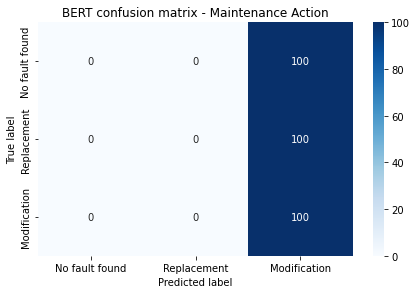

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.33      0.50       300
           2       0.00      0.00      0.00         0

    accuracy                           0.33       300
   macro avg       0.33      0.11      0.17       300
weighted avg       1.00      0.33      0.50       300



In [134]:
# -- Confusion matrix -- 
Class=['No fault found','Replacement','Modification']
y_pred1 = tf.nn.softmax(model.predict(x2_test))


plt.title('BERT confusion matrix - Maintenance Action')

# Convert the one-hot vectors to labels
y_train_labels1 = tf.math.argmax(y_pred1, axis=1)

cm_train1 = tf.math.confusion_matrix(y_test, y_train_labels1).numpy()

#con_mat_df = pd.DataFrame(cm_train)

# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df1 = pd.DataFrame(cm_train1)
                 

sns.heatmap(data=cm_df1, annot=True,fmt='g', cmap=plt.cm.Blues, xticklabels=Class,yticklabels=Class)
            
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(classification_report(y_train_labels, y_test))


## Applying the Sequential Model

In [135]:
from keras.models import Sequential
from keras import layers
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)

tokenizer.fit_on_texts(x_train)
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

tokenizer.fit_on_texts(x2_train)
x2_train = tokenizer.texts_to_sequences(x2_train)
x2_test = tokenizer.texts_to_sequences(x2_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index


#### Adding Padding

In [136]:
#performing padding to be equalize the lenght 
from keras.preprocessing.sequence import pad_sequences

maxlen = 200

x_train = pad_sequences(x_train, padding='post', maxlen=maxlen)
x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)


In [137]:
#performing padding to be equalize the lenght 
from keras.preprocessing.sequence import pad_sequences

maxlen = 200

x2_train = pad_sequences(x2_train, padding='post', maxlen=maxlen)
x2_test = pad_sequences(x2_test, padding='post', maxlen=maxlen)


In [138]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential

embedding_dim = 200

model1 = Sequential()
model1.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model1.add(layers.Flatten())
model1.add(layers.Dense(10, activation='relu'))
model1.add(layers.Dense(3, activation='softmax'))
model1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])    
    
model1.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 200)          703400    
                                                                 
 flatten (Flatten)           (None, 40000)             0         
                                                                 
 dense (Dense)               (None, 10)                400010    
                                                                 
 dense_1 (Dense)             (None, 3)                 33        
                                                                 
Total params: 1,103,443
Trainable params: 1,103,443
Non-trainable params: 0
_________________________________________________________________


## For Fault Notification

Training Accuracy: 0.3333
Testing Accuracy:  0.3333


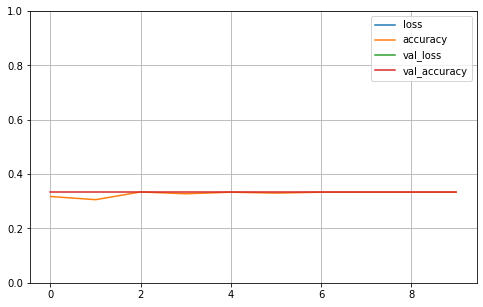

In [139]:

history= model1.fit(x_train, y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=(x_test, y_test))
                    

loss, accuracy = model1.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model1.evaluate(x_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))


#plot_history(history)

import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()



In [140]:
model1.evaluate(x_test, y_test)

10/10 [==============================] - 0s 4ms/step - loss: 1.0986 - accuracy: 0.3333


[1.098612666130066, 0.3333333432674408]

In [141]:
# Making prediction with the first 10 samples from the text fault notification test set.
x_new = x_test[:10]
y_proba = model1.predict(x_new)
y_proba.round(2)



array([[0.33, 0.33, 0.33],
       [0.33, 0.33, 0.33],
       [0.33, 0.33, 0.33],
       [0.33, 0.33, 0.33],
       [0.33, 0.33, 0.33],
       [0.33, 0.33, 0.33],
       [0.33, 0.33, 0.33],
       [0.33, 0.33, 0.33],
       [0.33, 0.33, 0.33],
       [0.33, 0.33, 0.33]], dtype=float32)

In [142]:
y_predicted=model1.predict
y_predicted =np.argmax(model1.predict(x_test[:10]), axis=-1)
y_predicted


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

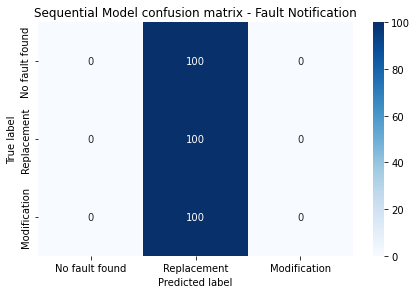

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.33      0.50       300
           2       0.00      0.00      0.00         0

    accuracy                           0.33       300
   macro avg       0.33      0.11      0.17       300
weighted avg       1.00      0.33      0.50       300



In [143]:
# -- Confusion matrix -- 
Class=['No fault found','Replacement','Modification']
y_pred1 = tf.nn.softmax(model1.predict(x_test))


plt.title('Sequential Model confusion matrix - Fault Notification')

# Convert the one-hot vectors to labels
y_train_labels1 = tf.math.argmax(y_pred1, axis=1)

cm_train1 = tf.math.confusion_matrix(y_test, y_train_labels1).numpy()

#con_mat_df = pd.DataFrame(cm_train)

# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df1 = pd.DataFrame(cm_train1)
                 

sns.heatmap(data=cm_df1, annot=True,fmt='g', cmap=plt.cm.Blues, xticklabels=Class,yticklabels=Class)
            
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(classification_report(y_train_labels, y_test))
#visualize_confusion_matrix(y_train_labels, y_test)

### For Maintenance Action

In [144]:
#performing padding to be equal to the maximum lenght for Maintenance action which is 986 

from keras.preprocessing.sequence import pad_sequences

maxlen = 200
x2_train = pad_sequences(x2_train, padding='post', maxlen=maxlen)
x2_test = pad_sequences(x2_test, padding='post', maxlen=maxlen)

Training Accuracy: 0.3333
Testing Accuracy:  0.3333


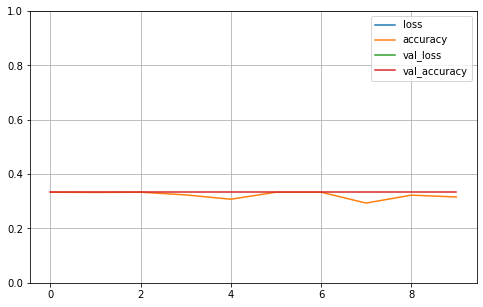

In [145]:
history = model1.fit(x2_train, y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=(x2_test, y_test))
                    
loss, accuracy = model1.evaluate(x2_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model1.evaluate(x2_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

#plot_history(history)

import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()


In [146]:
model1.evaluate(x_test, y_test)

10/10 [==============================] - 0s 5ms/step - loss: 1.0986 - accuracy: 0.3333


[1.098616123199463, 0.3333333432674408]

In [147]:
# Making prediction with the first 10 samples from the text maintenance action test set.
x_new = x2_test[:10]
y_proba = model1.predict(x_new)
y_proba.round(2)


array([[0.33, 0.33, 0.33],
       [0.33, 0.33, 0.33],
       [0.33, 0.33, 0.33],
       [0.33, 0.33, 0.33],
       [0.33, 0.33, 0.33],
       [0.33, 0.33, 0.33],
       [0.33, 0.33, 0.33],
       [0.33, 0.33, 0.33],
       [0.33, 0.33, 0.33],
       [0.33, 0.33, 0.33]], dtype=float32)

In [148]:
y_predicted=model1.predict
y_predicted =np.argmax(model1.predict(x2_test[:10]), axis=-1)
y_predicted

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

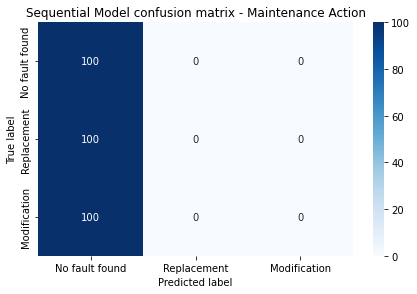

              precision    recall  f1-score   support

           0       1.00      0.33      0.50       300
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0

    accuracy                           0.33       300
   macro avg       0.33      0.11      0.17       300
weighted avg       1.00      0.33      0.50       300



In [149]:
# -- Confusion matrix -- 
Class=['No fault found','Replacement','Modification']
y_pred1 = tf.nn.softmax(model1.predict(x2_test))


plt.title('Sequential Model confusion matrix - Maintenance Action')

# Convert the one-hot vectors to labels
y_train_labels1 = tf.math.argmax(y_pred1, axis=1)

cm_train1 = tf.math.confusion_matrix(y_test, y_train_labels1).numpy()


# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df1 = pd.DataFrame(cm_train1)
                 

sns.heatmap(data=cm_df1, annot=True,fmt='g', cmap=plt.cm.Blues, xticklabels=Class,yticklabels=Class)
            
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(classification_report(y_train_labels1, y_test))

### Implementing Convolutional Network

In [150]:
embedding_dim = 200

model3 = Sequential()
model3.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model3.add(layers.Conv1D(128, 5, activation='relu'))
model3.add(layers.GlobalMaxPooling1D())
model3.add(layers.Dense(10, activation='relu'))
model3.add(layers.Dense(3, activation='softmax'))
model3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 200)          703400    
                                                                 
 conv1d (Conv1D)             (None, 196, 128)          128128    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
 dense_3 (Dense)             (None, 3)                 33        
                                                                 
Total params: 832,851
Trainable params: 832,851
Non-trainable params: 0
________________________________________________

### For Fault Notification

Training Accuracy: 0.9358
Testing Accuracy:  0.3367


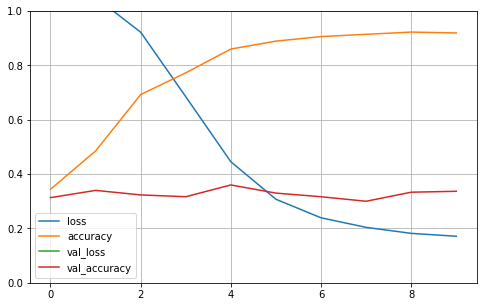

In [151]:
model3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


history = model3.fit(x_train, y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=(x_test, y_test))
                    
loss, accuracy = model3.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model3.evaluate(x_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))


import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [152]:
# Making prediction with the first 10 samples from the text in fault notification test set.
x_new = x_test[:10]
y_proba = model3.predict(x_new)
y_proba.round(2)


array([[0.69, 0.1 , 0.21],
       [0.82, 0.08, 0.1 ],
       [0.34, 0.28, 0.38],
       [0.1 , 0.07, 0.83],
       [0.02, 0.94, 0.04],
       [0.64, 0.18, 0.18],
       [0.93, 0.07, 0.  ],
       [0.02, 0.18, 0.8 ],
       [0.12, 0.44, 0.43],
       [0.49, 0.24, 0.27]], dtype=float32)

In [153]:
y_predicted=model3.predict
y_predicted =np.argmax(model3.predict(x_test[:10]), axis=-1)
y_predicted

array([0, 0, 2, 2, 1, 0, 0, 2, 1, 0], dtype=int64)

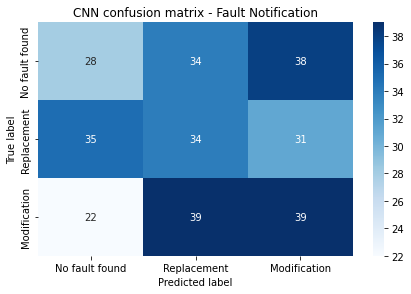

              precision    recall  f1-score   support

           0       0.28      0.33      0.30        85
           1       0.34      0.32      0.33       107
           2       0.39      0.36      0.38       108

    accuracy                           0.34       300
   macro avg       0.34      0.34      0.34       300
weighted avg       0.34      0.34      0.34       300



In [154]:
# -- Confusion matrix -- 
Class=['No fault found','Replacement','Modification']
y_pred1 = tf.nn.softmax(model3.predict(x_test))

plt.title('CNN confusion matrix - Fault Notification')

# Convert the one-hot vectors to labels
y_train_labels1 = tf.math.argmax(y_pred1, axis=1)

cm_train1 = tf.math.confusion_matrix(y_test, y_train_labels1).numpy()

# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df1 = pd.DataFrame(cm_train1)
                 

sns.heatmap(data=cm_df1, annot=True,fmt='g', cmap=plt.cm.Blues, xticklabels=Class,yticklabels=Class)
            
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(classification_report(y_train_labels1, y_test))


### For Maintenance Action

Training Accuracy: 0.9942
Testing Accuracy:  0.9433


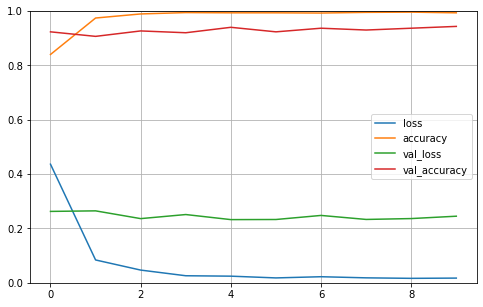

In [155]:
history = model3.fit(x2_train, y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=(x2_test, y_test))
loss, accuracy = model3.evaluate(x2_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model3.evaluate(x2_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))


import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()



In [156]:
# Making prediction with the first 10 samples from the text int he Maintenance Action test set.
x_new = x2_test[:10]
y_proba = model3.predict(x_new)
y_proba.round(2)


array([[0.  , 0.95, 0.05],
       [0.  , 1.  , 0.  ],
       [0.  , 0.99, 0.01],
       [0.  , 1.  , 0.  ],
       [0.  , 0.  , 1.  ],
       [0.  , 1.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  ],
       [0.  , 1.  , 0.  ]], dtype=float32)

In [157]:
y_predicted=model.predict
y_predicted =np.argmax(model3.predict(x2_test[:10]), axis=-1)
y_predicted

array([1, 1, 1, 1, 2, 1, 0, 0, 1, 1], dtype=int64)

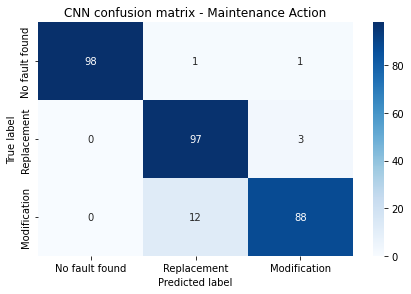

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        98
           1       0.97      0.88      0.92       110
           2       0.88      0.96      0.92        92

    accuracy                           0.94       300
   macro avg       0.94      0.95      0.94       300
weighted avg       0.95      0.94      0.94       300



In [158]:
# -- Confusion matrix -- 
Class=['No fault found','Replacement','Modification']
y_pred1 = tf.nn.softmax(model3.predict(x2_test))


plt.title('CNN confusion matrix - Maintenance Action')

# Convert the vectors to labels
y_train_labels1 = tf.math.argmax(y_pred1, axis=1)

cm_train1 = tf.math.confusion_matrix(y_test, y_train_labels1).numpy()

# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df1 = pd.DataFrame(cm_train1)
                 

sns.heatmap(data=cm_df1, annot=True,fmt='g', cmap=plt.cm.Blues, xticklabels=Class,yticklabels=Class)
            
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(classification_report(y_train_labels1, y_test))
#visualize_confusion_matrix(y_train_labels, y_test)

### For the prediction and classification of expert action using the Neural Network classifiers, the Convolutional Network outperformed all the other predictors by achieving 94% level of accuracy for the fault notification document and 99% for the maintenance action document. Thus proving to be the most suitable algorithm for text classification tasks for the provision of support to expert systems and decision makers in MRO (Maintenance, Repair and Overhaul) services. 